In [1]:
#IMPORTS
import numpy as np
from PIL import Image
import math
import cv2

In [2]:
#FILTERS
blur_filter = np.array([[0.0625,0.125,0.0625],[0.125,0.250,0.125],[0.0625,0.125,0.0625]], dtype=np.float32)
outline_filter = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]], dtype=np.float32)
emboss_filter = np.array([[-2,-1,0],[-1,1,1],[0,1,2]], dtype=np.float32)

#FILTER USED 
global used_filter
used_filter = blur_filter

#GLOBAL VARIABLES
global DIM
DIM = 8
global FL
FL = 4
global IL
IL = 8
global e
e = pow(2,-FL)
global n_max
n_max = pow(2,IL-1) - e
global n_min
n_min = -1*pow(2,IL-1)

In [3]:
#DISPARITY function
def disparity(image,image_conv):
    stereo_matcher = cv2.StereoSGBM_create(numDisparities = 2, blockSize = 5)
    disparity = stereo_matcher.compute(np.array(image),np.array(image_conv))
    disparity = (disparity).astype(np.uint8)
    disparity = cv2.applyColorMap(disparity, cv2.COLORMAP_JET)
    return Image.fromarray(disparity,'RGB')

In [4]:
#ELABORATION
def elaboration(P):
    N = P // e
    p = (P - N*e) / e
    rand = np.random.normal(0,1,1)
    if rand <= p:
        return N*e
    else:
        return (N+1)*e

In [5]:
#CONVERSION
def conversion(Z):
    if Z > n_max:
        return n_max
    elif Z < n_min:
        return n_min
    else:
        return Z

In [6]:
def convert_and_compute(P):
    P = P/pow(2,FL)
    P = conversion( elaboration(P) )
    pix = int(P)
    return pix 

In [7]:
#CONVERSION
def conv(image):
    output = image.astype(int)
    width = len(image)
    height = len(image[0])
    
    for i in range(0,width):
    #iterating in a column
        for j in range(0,height):
            #iterating in greyscale
            output[i][j] = convert_and_compute(image[i][j])
   
    return output

[[ 84  83  82 ... 101 101 101]
 [ 84  83  82 ... 101 101 102]
 [ 83  83  82 ... 101 102 102]
 ...
 [148 110  86 ... 148 193 180]
 [ 80  85  96 ... 156 171 122]
 [ 33  54  66 ... 150  86 105]]


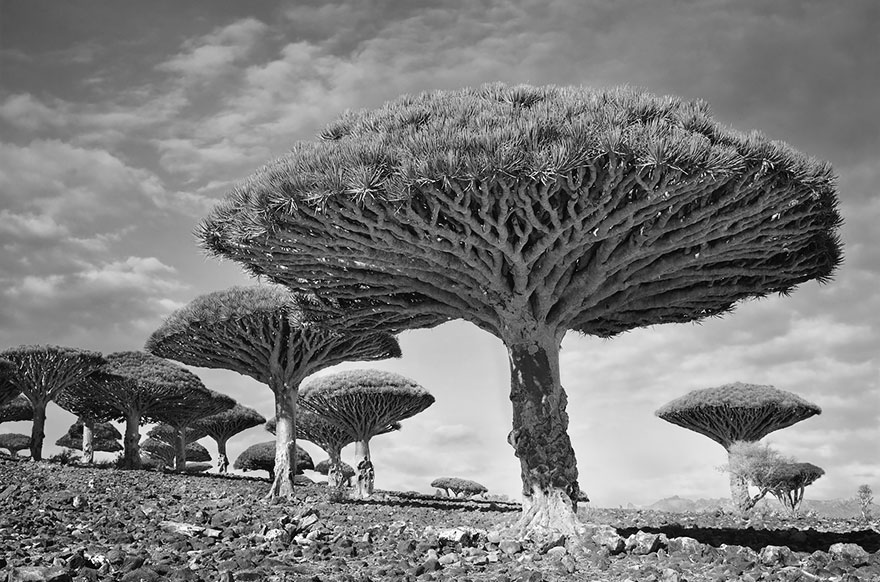

In [8]:
#getting the image and printing it
image = Image.open("tree.jpg")
image = image.convert("L")

print(np.array(image))
image

In [9]:
#shift of FL to left bits of a pixel example
x = conversion( elaboration(127) )
print(x)
print(x*pow(2,FL))

127.0625
2033.0


In [10]:
#shift of FL to left bits of the image pixels
npImage = np.array(image).astype(np.float32)
width = len(npImage)
height = len(npImage[0])

for i in range(0,width):
#iterating in a column
    for j in range(0,height):
        #iterating in greyscale
        npImage[i][j] = npImage[i][j]*pow(2,FL)

print(npImage)

[[1344. 1328. 1312. ... 1616. 1616. 1616.]
 [1344. 1328. 1312. ... 1616. 1616. 1632.]
 [1328. 1328. 1312. ... 1616. 1632. 1632.]
 ...
 [2368. 1760. 1376. ... 2368. 3088. 2880.]
 [1280. 1360. 1536. ... 2496. 2736. 1952.]
 [ 528.  864. 1056. ... 2400. 1376. 1680.]]


In [11]:
#kernel conversion
kernel = np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]).reshape(3,3)

for i in range(0,3):
    for j in range(0,3):
        kernel[i][j] = conversion( elaboration(used_filter[i][j]) )

print(kernel)

[[0.0625 0.1875 0.125 ]
 [0.125  0.3125 0.1875]
 [0.0625 0.1875 0.125 ]]


In [12]:
#convolution(traditional)
dst = cv2.filter2D(npImage,-1,kernel)
print(dst)
npImage = conv(dst)

[[1837. 1823. 1801. ... 2222. 2226. 2228.]
 [1834. 1822. 1801. ... 2223. 2230. 2233.]
 [1826. 1815. 1795. ... 2224. 2237. 2241.]
 ...
 [2307. 2267. 2458. ... 3610. 3707. 3728.]
 [1860. 1850. 1993. ... 3394. 3238. 3157.]
 [1425. 1588. 1852. ... 3274. 2871. 2713.]]


In [13]:
npImage = npImage.astype(np.uint8)
width = len(npImage)
height = len(npImage[0])
print(width,height)
print(npImage)
#npImage = npImage.astype(np.uint8)

582 880
[[114 114 112 ... 127 127 127]
 [114 113 112 ... 127 127 127]
 [114 113 112 ... 127 127 127]
 ...
 [127 127 127 ... 127 127 127]
 [116 115 124 ... 127 127 127]
 [ 89  99 115 ... 127 127 127]]


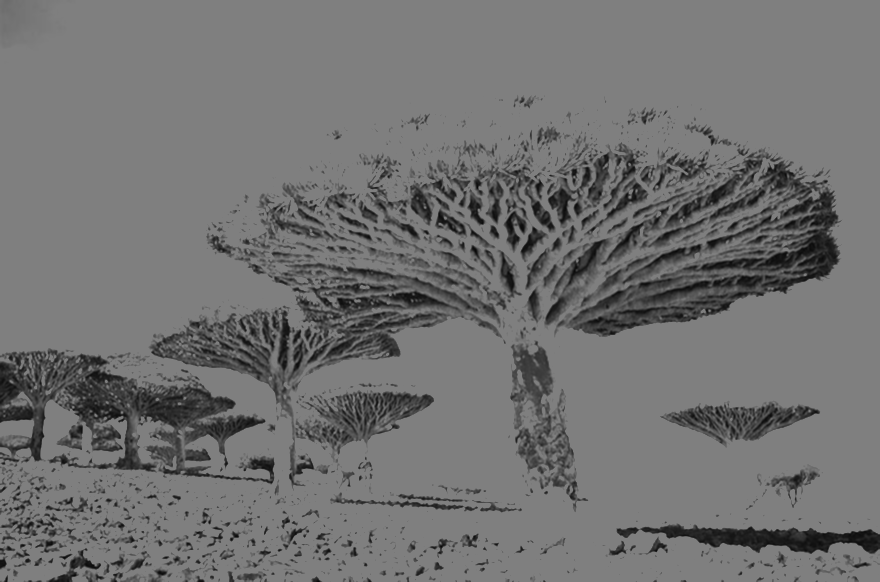

In [14]:
imgRes = Image.fromarray(npImage,'L')
imgRes

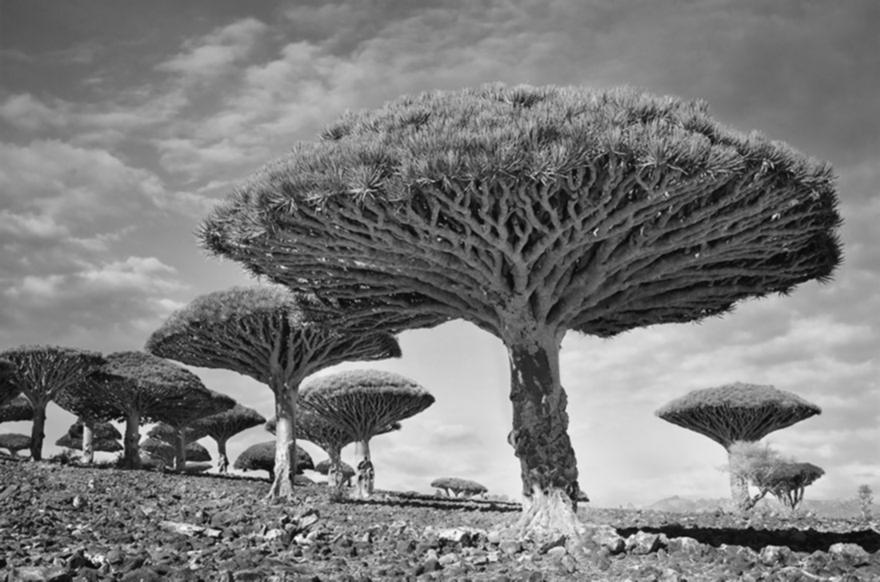

In [15]:
#without the algorithm
imgConvdst = cv2.filter2D(np.array(image),-1,used_filter)
imgConvTrad = Image.fromarray(imgConvdst, 'L')
imgConvTrad

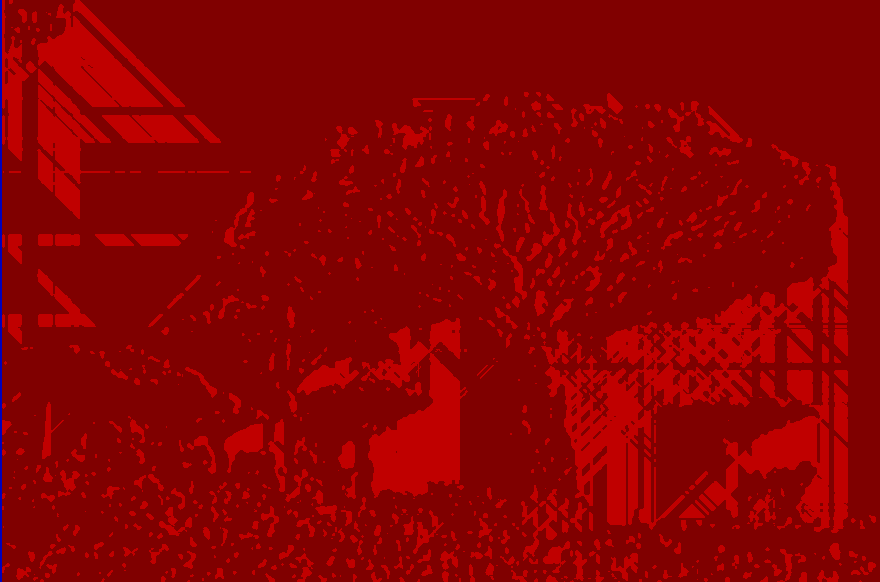

In [16]:
disparity(imgConvTrad,imgRes)